In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import glob
import re
import random
import cv2
from sklearn.model_selection import train_test_split
from imgaug import augmenters as img_aug
from tensorflow.keras.optimizers import Adam
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

/Users/xmxhuihui/Jupyter Notebook/Tensorflow/Self_Driving_Car_Project/Figures/Track/1582896926324_100_35.png
(240, 320, 3)


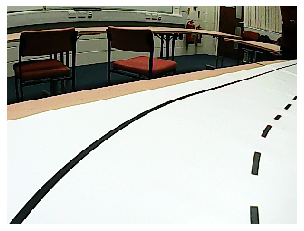

In [2]:
PATH='/Users/xmxhuihui/Jupyter Notebook/Tensorflow/Self_Driving_Car_Project/Figures/Track'
IMAGE_PATHS=glob.glob(os.path.join(PATH,'*.png'))
#Sample image and shape
sp0=plt.imread(IMAGE_PATHS[10])
plt.axis('off')
print(IMAGE_PATHS[10])
print(sp0.shape)
plt.imshow(sp0)

In [3]:
image_paths=[]
steering_angles=[]
for image_path in IMAGE_PATHS:
    val=re.findall(r'_(\d+)_',os.path.basename(image_path))
    angle=int(val[0])
    image_paths.append(image_path)
    steering_angles.append(angle)
print(len(image_paths))
print(len(steering_angles))

664
664


In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steering_angles, test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))

Training data: 531
Validation data: 133


In [5]:
def zoom(image):
    zoom = img_aug.Affine(scale=(1, 1.3))  # zoom from 100% (no zoom) to 130%
    image = zoom.augment_image(image)
    return image
def pan(image):
    # pan left / right / up / down about 10%
    pan = img_aug.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image
def random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = 180 - steering_angle
    return image, steering_angle
def adjust_brightness(image):
    # increase or decrease brightness by 30%
    brightness = img_aug.Multiply((0.7, 1.3))
    image = brightness.augment_image(image)
    return image
def blur(image):
    kernel_size = random.randint(1, 5)  # kernel larger than 5 would make the image way too blurry
    image = cv2.blur(image,(kernel_size, kernel_size))
   
    return image
def random_augment(image, steering_angle):
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = blur(image)
    if np.random.rand() < 0.5:
        image = adjust_brightness(image)
    if np.random.rand() < 0.5:
        image, steering_angle = random_flip(image, steering_angle)
    
    return image, steering_angle

In [6]:
def image_preprocessing(image):
    height, _, _ = image.shape
    image = image[int(height/2):,:,:]  # remove top half of the image, as it is not relavant for lane following
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  # Nvidia model said it is best to use YUV color space
    image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.resize(image, (200,66)) # input image size (200,66) Nvidia model
    image = image / 255.0 # normalizing, the processed image becomes black for some reason.  do we need this?
    return image

In [7]:
def image_data_generator(image_paths, steering_angles, batch_size, is_training):
    while True:
        batch_images = []
        batch_steering_angles = []
        
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            image_path = image_paths[random_index]
            image = cv2.imread(image_paths[random_index])
            steering_angle = steering_angles[random_index]
            if is_training:
                # training: augment image
                image, steering_angle = random_augment(image, steering_angle)
            image = image_preprocessing(image)
            batch_images.append(image)
            batch_steering_angles.append(steering_angle)
            
        yield( np.asarray(batch_images), np.asarray(batch_steering_angles))

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(24, (5, 5), strides=(2,2), activation='relu', input_shape=(66, 200, 3)),
    tf.keras.layers.Conv2D(36, (5, 5), strides=(2,2), activation='relu'),
    tf.keras.layers.Conv2D(48, (5, 5), strides=(2,2), activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])
optimizer = Adam(lr=1e-3)
model.compile(optimizer = optimizer,
              loss = 'mse')

In [9]:
checkpoint_dir='/Users/xmxhuihui/Jupyter Notebook/Tensorflow/Self_Driving_Car_Project/training_checkpoints2'
#checkpoint = tf.train.Checkpoint(model=model)
#try:
#    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
#except Exception:
#    pass
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir, verbose=1, save_best_only=True)
history = model.fit_generator(image_data_generator( X_train, y_train, batch_size=100, is_training=True),
                              steps_per_epoch=300,
                              epochs=10,
                              validation_data = image_data_generator( X_valid, y_valid, batch_size=100, is_training=False),
                              validation_steps=200,
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])
model.save(checkpoint_dir)

Epoch 1/10
299/300 [============================>.] - ETA: 0s - loss: 3847.8351
Epoch 00001: val_loss improved from inf to 247.42767, saving model to /Users/xmxhuihui/Jupyter Notebook/Tensorflow/Self_Driving_Car_Project/training_checkpoints2
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /Users/xmxhuihui/Jupyter Notebook/Tensorflow/Self_Driving_Car_Project/training_checkpoints2/assets
300/300 [==============================] - 242s 805ms/step - loss: 3835.8267 - val_loss: 247.4277
Epoch 2/10
299/300 [============================>.] - ETA: 0s - loss: 274.5229
Epoch 00002: val_loss improved from 247.42767 to 245.22949, saving model to /Users/xmxhuihui/Jupyter Notebook/Tensorflow/Self_Driving_Car_Project/training_checkpoints2
INFO:tensorflow:Assets written to: /Users/xmxhuihui/Jupyter Notebook/Tensorflow/Self_Driving_Car_Project/training_checkpoints2/assets
300/300 [==============================] - 241s 804ms/step - los

KeyboardInterrupt: 

In [ ]:
plt.figure()
plt.plot(history.history['loss'],color='blue')
plt.plot(history.history['val_loss'],color='red')
plt.legend(["training loss", "validation loss"])
plt.show()

In [ ]:
TEST_IMAGE_PATH='/Users/xmxhuihui/Jupyter Notebook/Tensorflow/Self_Driving_Car_Project/mlis2020/test_data/test_data'
print(len(os.listdir(TEST_IMAGE_PATH)))
TEST_IMAGE_PATHS=glob.glob(os.path.join(TEST_IMAGE_PATH,'*.png'))
print(len(TEST_IMAGE_PATHS))
Y_pred=np.zeros(len(TEST_IMAGE_PATHS))
for test_image in TEST_IMAGE_PATHS:
    test_image_data_array=[]
    image_index=int(re.findall(r'(\d+).png',test_image)[0])
    print(image_index)
    test_image_data=cv2.imread(test_image)
    test_image_data=image_preprocessing(test_image_data)
    test_image_data_array.append(test_image_data)
    y_pred=model.predict(np.asarray(test_image_data_array))
    Y_pred[image_index-1]=y_pred
print(Y_pred)

In [ ]:
Y_pred=(Y_pred-50)/80
print(Y_pred)

In [ ]:
table=pd.read_csv('/Users/xmxhuihui/Jupyter Notebook/Tensorflow/Self_Driving_Car_Project/table/Submission2.csv')
table.head()

In [ ]:
table['angle']=Y_pred
table=table.reindex(columns=['image_id','angle','speed'])
table.head()
table.to_csv('/Users/xmxhuihui/Jupyter Notebook/Tensorflow/Self_Driving_Car_Project/table/Submission2.csv',index=False)